# Braid Groups: An Introduction to Algebraic Topology

## 1. Introduction

Braid groups are fundamental algebraic structures that arise naturally in topology, algebra, and mathematical physics. First studied systematically by Emil Artin in the 1920s, braid groups provide a rigorous framework for understanding the mathematics of intertwining strands.

## 2. Geometric Definition

Consider $n$ points in the plane $\mathbb{R}^2$, positioned at coordinates $(1, 0), (2, 0), \ldots, (n, 0)$. A **braid on $n$ strands** is a collection of $n$ non-intersecting curves (strands) in $\mathbb{R}^2 \times [0, 1]$, where:

- Each strand connects a point $(i, 0, 0)$ to some point $(\sigma(i), 0, 1)$ where $\sigma$ is a permutation of $\{1, 2, \ldots, n\}$
- Strands are monotonic in the $t$-direction (they always "move upward")
- Strands never intersect each other

## 3. Algebraic Structure

The **braid group on $n$ strands**, denoted $B_n$, has the following presentation:

$$B_n = \left\langle \sigma_1, \sigma_2, \ldots, \sigma_{n-1} \;\middle|\; \begin{array}{l} \sigma_i \sigma_j = \sigma_j \sigma_i \text{ for } |i-j| \geq 2 \\ \sigma_i \sigma_{i+1} \sigma_i = \sigma_{i+1} \sigma_i \sigma_{i+1} \end{array} \right\rangle$$

Here, $\sigma_i$ represents the elementary braid where strand $i$ crosses **over** strand $i+1$.

### 3.1 Artin Relations

The two types of relations are:

1. **Far commutativity**: $\sigma_i \sigma_j = \sigma_j \sigma_i$ for $|i - j| \geq 2$
   
   This states that crossings involving non-adjacent strands can be performed in any order.

2. **Braid relation (Yang-Baxter)**: $\sigma_i \sigma_{i+1} \sigma_i = \sigma_{i+1} \sigma_i \sigma_{i+1}$
   
   This is the famous Yang-Baxter equation, fundamental in quantum groups and statistical mechanics.

## 4. Connection to the Symmetric Group

There exists a natural surjective homomorphism:

$$\pi: B_n \to S_n$$

where $S_n$ is the symmetric group. This map sends each braid to the permutation it induces on the endpoints. The kernel of this map is the **pure braid group** $P_n$, consisting of braids where each strand returns to its starting position.

We have the short exact sequence:

$$1 \to P_n \to B_n \xrightarrow{\pi} S_n \to 1$$

## 5. Important Properties

- $B_1 = \{e\}$ (trivial group)
- $B_2 \cong \mathbb{Z}$ (infinite cyclic)
- For $n \geq 3$, $B_n$ is non-abelian and infinite
- The center of $B_n$ for $n \geq 3$ is generated by the **full twist**: $(\sigma_1 \sigma_2 \cdots \sigma_{n-1})^n$

## 6. Computational Implementation

We will now implement a visualization of braids and demonstrate key properties computationally.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors

# Set up plotting style
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 12

In [2]:
class Braid:
    """
    A class representing a braid on n strands.
    
    A braid is represented as a list of generators, where:
    - Positive integers i represent sigma_i (strand i crosses over strand i+1)
    - Negative integers -i represent sigma_i^{-1} (strand i+1 crosses over strand i)
    """
    
    def __init__(self, n_strands, generators=None):
        """
        Initialize a braid.
        
        Parameters:
        -----------
        n_strands : int
            Number of strands in the braid
        generators : list of int, optional
            List of generators (positive for over-crossing, negative for under-crossing)
        """
        self.n_strands = n_strands
        self.generators = generators if generators is not None else []
        self._validate()
    
    def _validate(self):
        """Validate that all generators are within bounds."""
        for g in self.generators:
            if abs(g) < 1 or abs(g) >= self.n_strands:
                raise ValueError(f"Generator {g} is out of bounds for {self.n_strands} strands")
    
    def __mul__(self, other):
        """Concatenate two braids (group operation)."""
        if self.n_strands != other.n_strands:
            raise ValueError("Cannot multiply braids with different number of strands")
        return Braid(self.n_strands, self.generators + other.generators)
    
    def inverse(self):
        """Return the inverse braid."""
        return Braid(self.n_strands, [-g for g in reversed(self.generators)])
    
    def permutation(self):
        """
        Compute the permutation induced by this braid.
        
        Returns:
        --------
        list : The permutation as a list where perm[i] is the destination of strand i
        """
        perm = list(range(self.n_strands))
        for g in self.generators:
            i = abs(g) - 1  # Convert to 0-indexed
            perm[i], perm[i+1] = perm[i+1], perm[i]
        return perm
    
    def is_pure(self):
        """Check if this is a pure braid (identity permutation)."""
        return self.permutation() == list(range(self.n_strands))
    
    def __repr__(self):
        if not self.generators:
            return f"Braid({self.n_strands}, identity)"
        gen_str = ' '.join([f'σ_{abs(g)}' if g > 0 else f'σ_{abs(g)}⁻¹' for g in self.generators])
        return f"Braid({self.n_strands}): {gen_str}"

In [3]:
def draw_braid(braid, ax=None, title=None, strand_colors=None):
    """
    Draw a visualization of a braid.
    
    Parameters:
    -----------
    braid : Braid
        The braid to visualize
    ax : matplotlib.axes.Axes, optional
        The axes to draw on
    title : str, optional
        Title for the plot
    strand_colors : list, optional
        Colors for each strand
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 10))
    
    n = braid.n_strands
    generators = braid.generators
    n_crossings = len(generators)
    
    # Set up colors
    if strand_colors is None:
        cmap = plt.cm.tab10
        strand_colors = [cmap(i % 10) for i in range(n)]
    
    # Track strand positions
    # positions[t][i] gives the x-position of strand i at time t
    positions = np.zeros((n_crossings + 1, n))
    positions[0] = np.arange(n)  # Initial positions
    
    # Compute positions after each crossing
    current_pos = list(range(n))
    strand_at_pos = list(range(n))  # strand_at_pos[x] = which strand is at position x
    
    for t, g in enumerate(generators):
        i = abs(g) - 1  # 0-indexed position of crossing
        # Swap the strands at positions i and i+1
        strand_at_pos[i], strand_at_pos[i+1] = strand_at_pos[i+1], strand_at_pos[i]
        # Update positions
        for x in range(n):
            positions[t+1, strand_at_pos[x]] = x
    
    # Drawing parameters
    height_per_crossing = 1.0
    total_height = (n_crossings + 1) * height_per_crossing
    
    # Draw each strand
    for strand in range(n):
        color = strand_colors[strand]
        
        for t in range(n_crossings):
            y_start = total_height - t * height_per_crossing
            y_end = total_height - (t + 1) * height_per_crossing
            x_start = positions[t, strand]
            x_end = positions[t + 1, strand]
            
            g = generators[t]
            crossing_pos = abs(g) - 1
            
            # Check if this strand is involved in the crossing
            if x_start == crossing_pos or x_start == crossing_pos + 1:
                # This strand is crossing
                # Determine if this strand goes over or under
                is_left_strand = (x_start == crossing_pos)
                goes_over = (g > 0 and is_left_strand) or (g < 0 and not is_left_strand)
                
                # Draw crossing with bezier curve
                t_vals = np.linspace(0, 1, 50)
                y_vals = y_start + (y_end - y_start) * t_vals
                
                # Smooth transition using cosine interpolation
                x_vals = x_start + (x_end - x_start) * (1 - np.cos(np.pi * t_vals)) / 2
                
                if goes_over:
                    # Draw the full strand (on top)
                    ax.plot(x_vals, y_vals, color=color, linewidth=4, solid_capstyle='round', zorder=3)
                else:
                    # Draw with a gap in the middle (underneath)
                    gap_start, gap_end = 0.35, 0.65
                    mask1 = t_vals < gap_start
                    mask2 = t_vals > gap_end
                    ax.plot(x_vals[mask1], y_vals[mask1], color=color, linewidth=4, 
                           solid_capstyle='round', zorder=2)
                    ax.plot(x_vals[mask2], y_vals[mask2], color=color, linewidth=4, 
                           solid_capstyle='round', zorder=2)
            else:
                # Strand not involved in crossing - draw straight
                ax.plot([x_start, x_end], [y_start, y_end], color=color, 
                       linewidth=4, solid_capstyle='round', zorder=1)
    
    # Add strand labels at top and bottom
    for i in range(n):
        ax.text(i, total_height + 0.2, f'{i+1}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    perm = braid.permutation()
    for i in range(n):
        final_pos = positions[-1, i]
        ax.text(final_pos, -0.2, f'{i+1}', ha='center', va='top', fontsize=12, fontweight='bold')
    
    # Add generator labels on the side
    for t, g in enumerate(generators):
        y_pos = total_height - (t + 0.5) * height_per_crossing
        label = f'$\\sigma_{{{abs(g)}}}$' if g > 0 else f'$\\sigma_{{{abs(g)}}}^{{-1}}$'
        ax.text(n + 0.3, y_pos, label, ha='left', va='center', fontsize=14)
    
    ax.set_xlim(-0.5, n + 1)
    ax.set_ylim(-0.5, total_height + 0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    
    if title:
        ax.set_title(title, fontsize=14, fontweight='bold')
    
    return ax

## 7. Visualizing Elementary Braids

Let us visualize the elementary generators $\sigma_1$ and $\sigma_2$ for $B_3$.

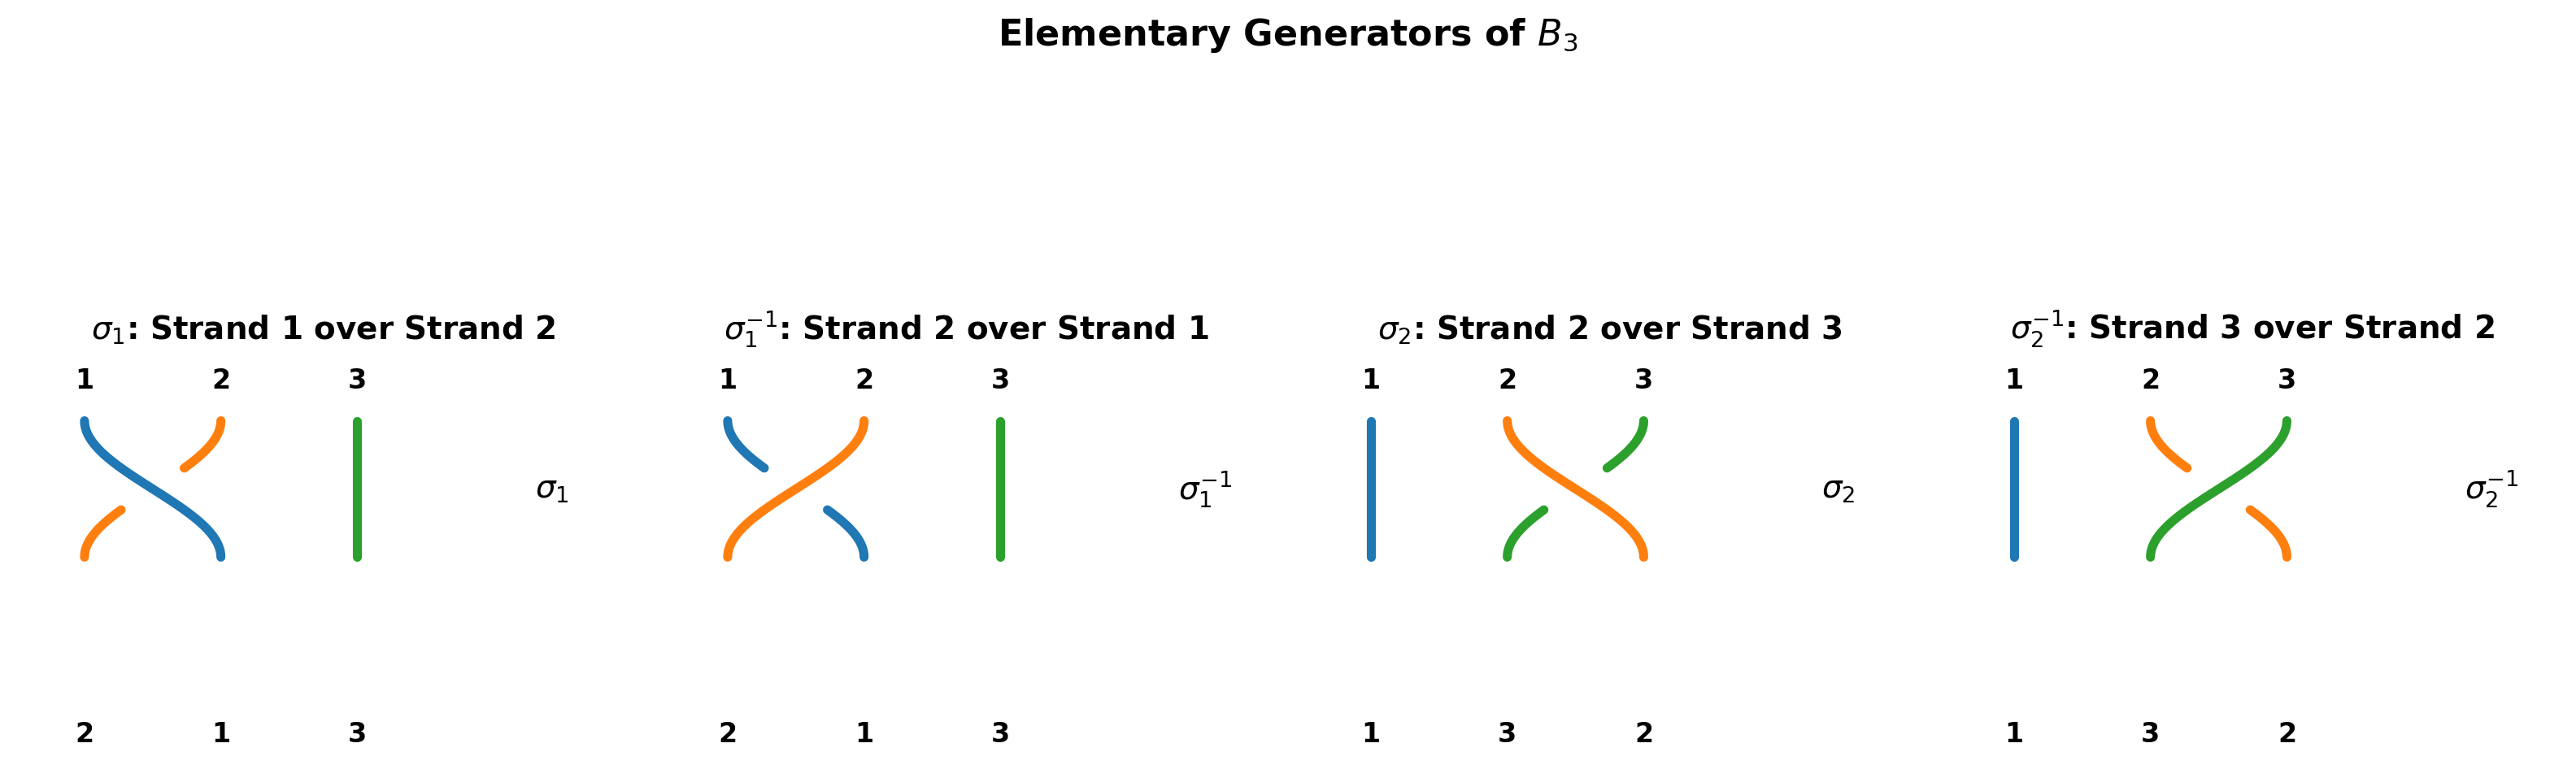

In [4]:
# Create elementary braids in B_3
sigma1 = Braid(3, [1])
sigma2 = Braid(3, [2])
sigma1_inv = Braid(3, [-1])
sigma2_inv = Braid(3, [-2])

fig, axes = plt.subplots(1, 4, figsize=(16, 6))

draw_braid(sigma1, axes[0], title=r'$\sigma_1$: Strand 1 over Strand 2')
draw_braid(sigma1_inv, axes[1], title=r'$\sigma_1^{-1}$: Strand 2 over Strand 1')
draw_braid(sigma2, axes[2], title=r'$\sigma_2$: Strand 2 over Strand 3')
draw_braid(sigma2_inv, axes[3], title=r'$\sigma_2^{-1}$: Strand 3 over Strand 2')

plt.suptitle('Elementary Generators of $B_3$', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 8. The Yang-Baxter Relation

The braid relation $\sigma_i \sigma_{i+1} \sigma_i = \sigma_{i+1} \sigma_i \sigma_{i+1}$ is also known as the Yang-Baxter equation. Let's verify this visually.

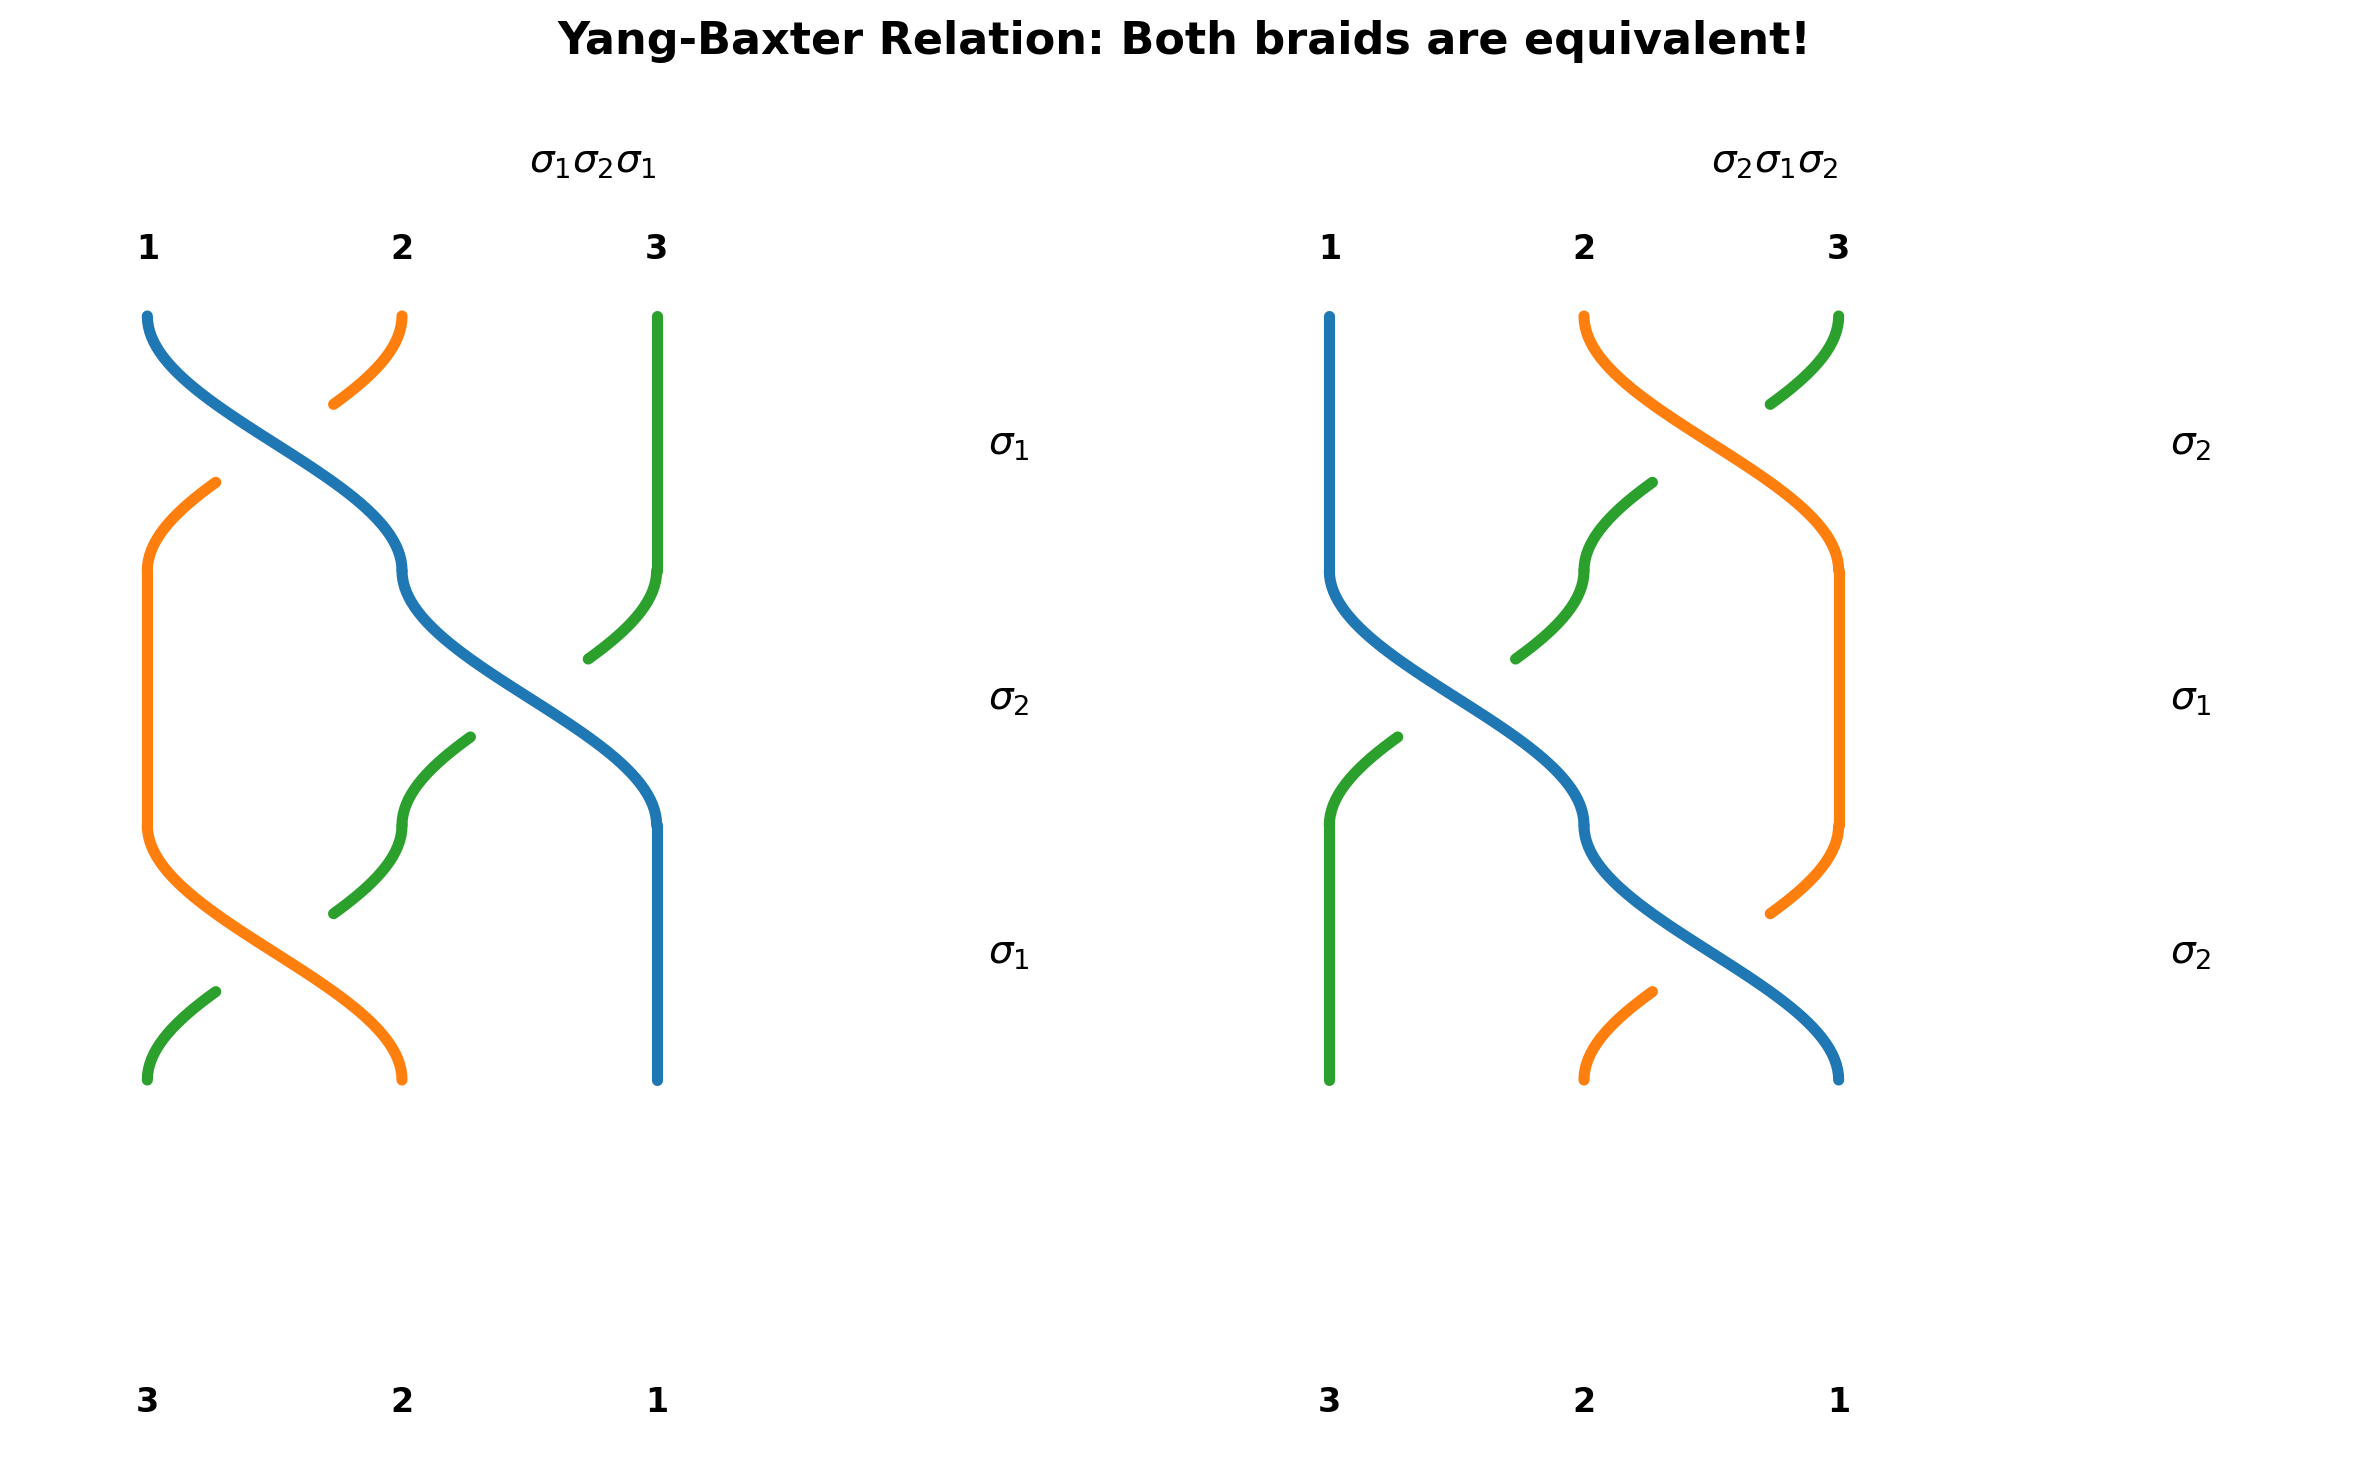

LHS permutation: [2, 1, 0]
RHS permutation: [2, 1, 0]
Permutations match: True


In [5]:
# Yang-Baxter relation: σ₁σ₂σ₁ = σ₂σ₁σ₂
lhs = Braid(3, [1, 2, 1])  # σ₁σ₂σ₁
rhs = Braid(3, [2, 1, 2])  # σ₂σ₁σ₂

fig, axes = plt.subplots(1, 2, figsize=(12, 8))

draw_braid(lhs, axes[0], title=r'$\sigma_1 \sigma_2 \sigma_1$')
draw_braid(rhs, axes[1], title=r'$\sigma_2 \sigma_1 \sigma_2$')

plt.suptitle('Yang-Baxter Relation: Both braids are equivalent!', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print(f"LHS permutation: {lhs.permutation()}")
print(f"RHS permutation: {rhs.permutation()}")
print(f"Permutations match: {lhs.permutation() == rhs.permutation()}")

## 9. Pure Braids

A **pure braid** is one where each strand returns to its starting position. The simplest non-trivial pure braid is $(\sigma_1)^2$.

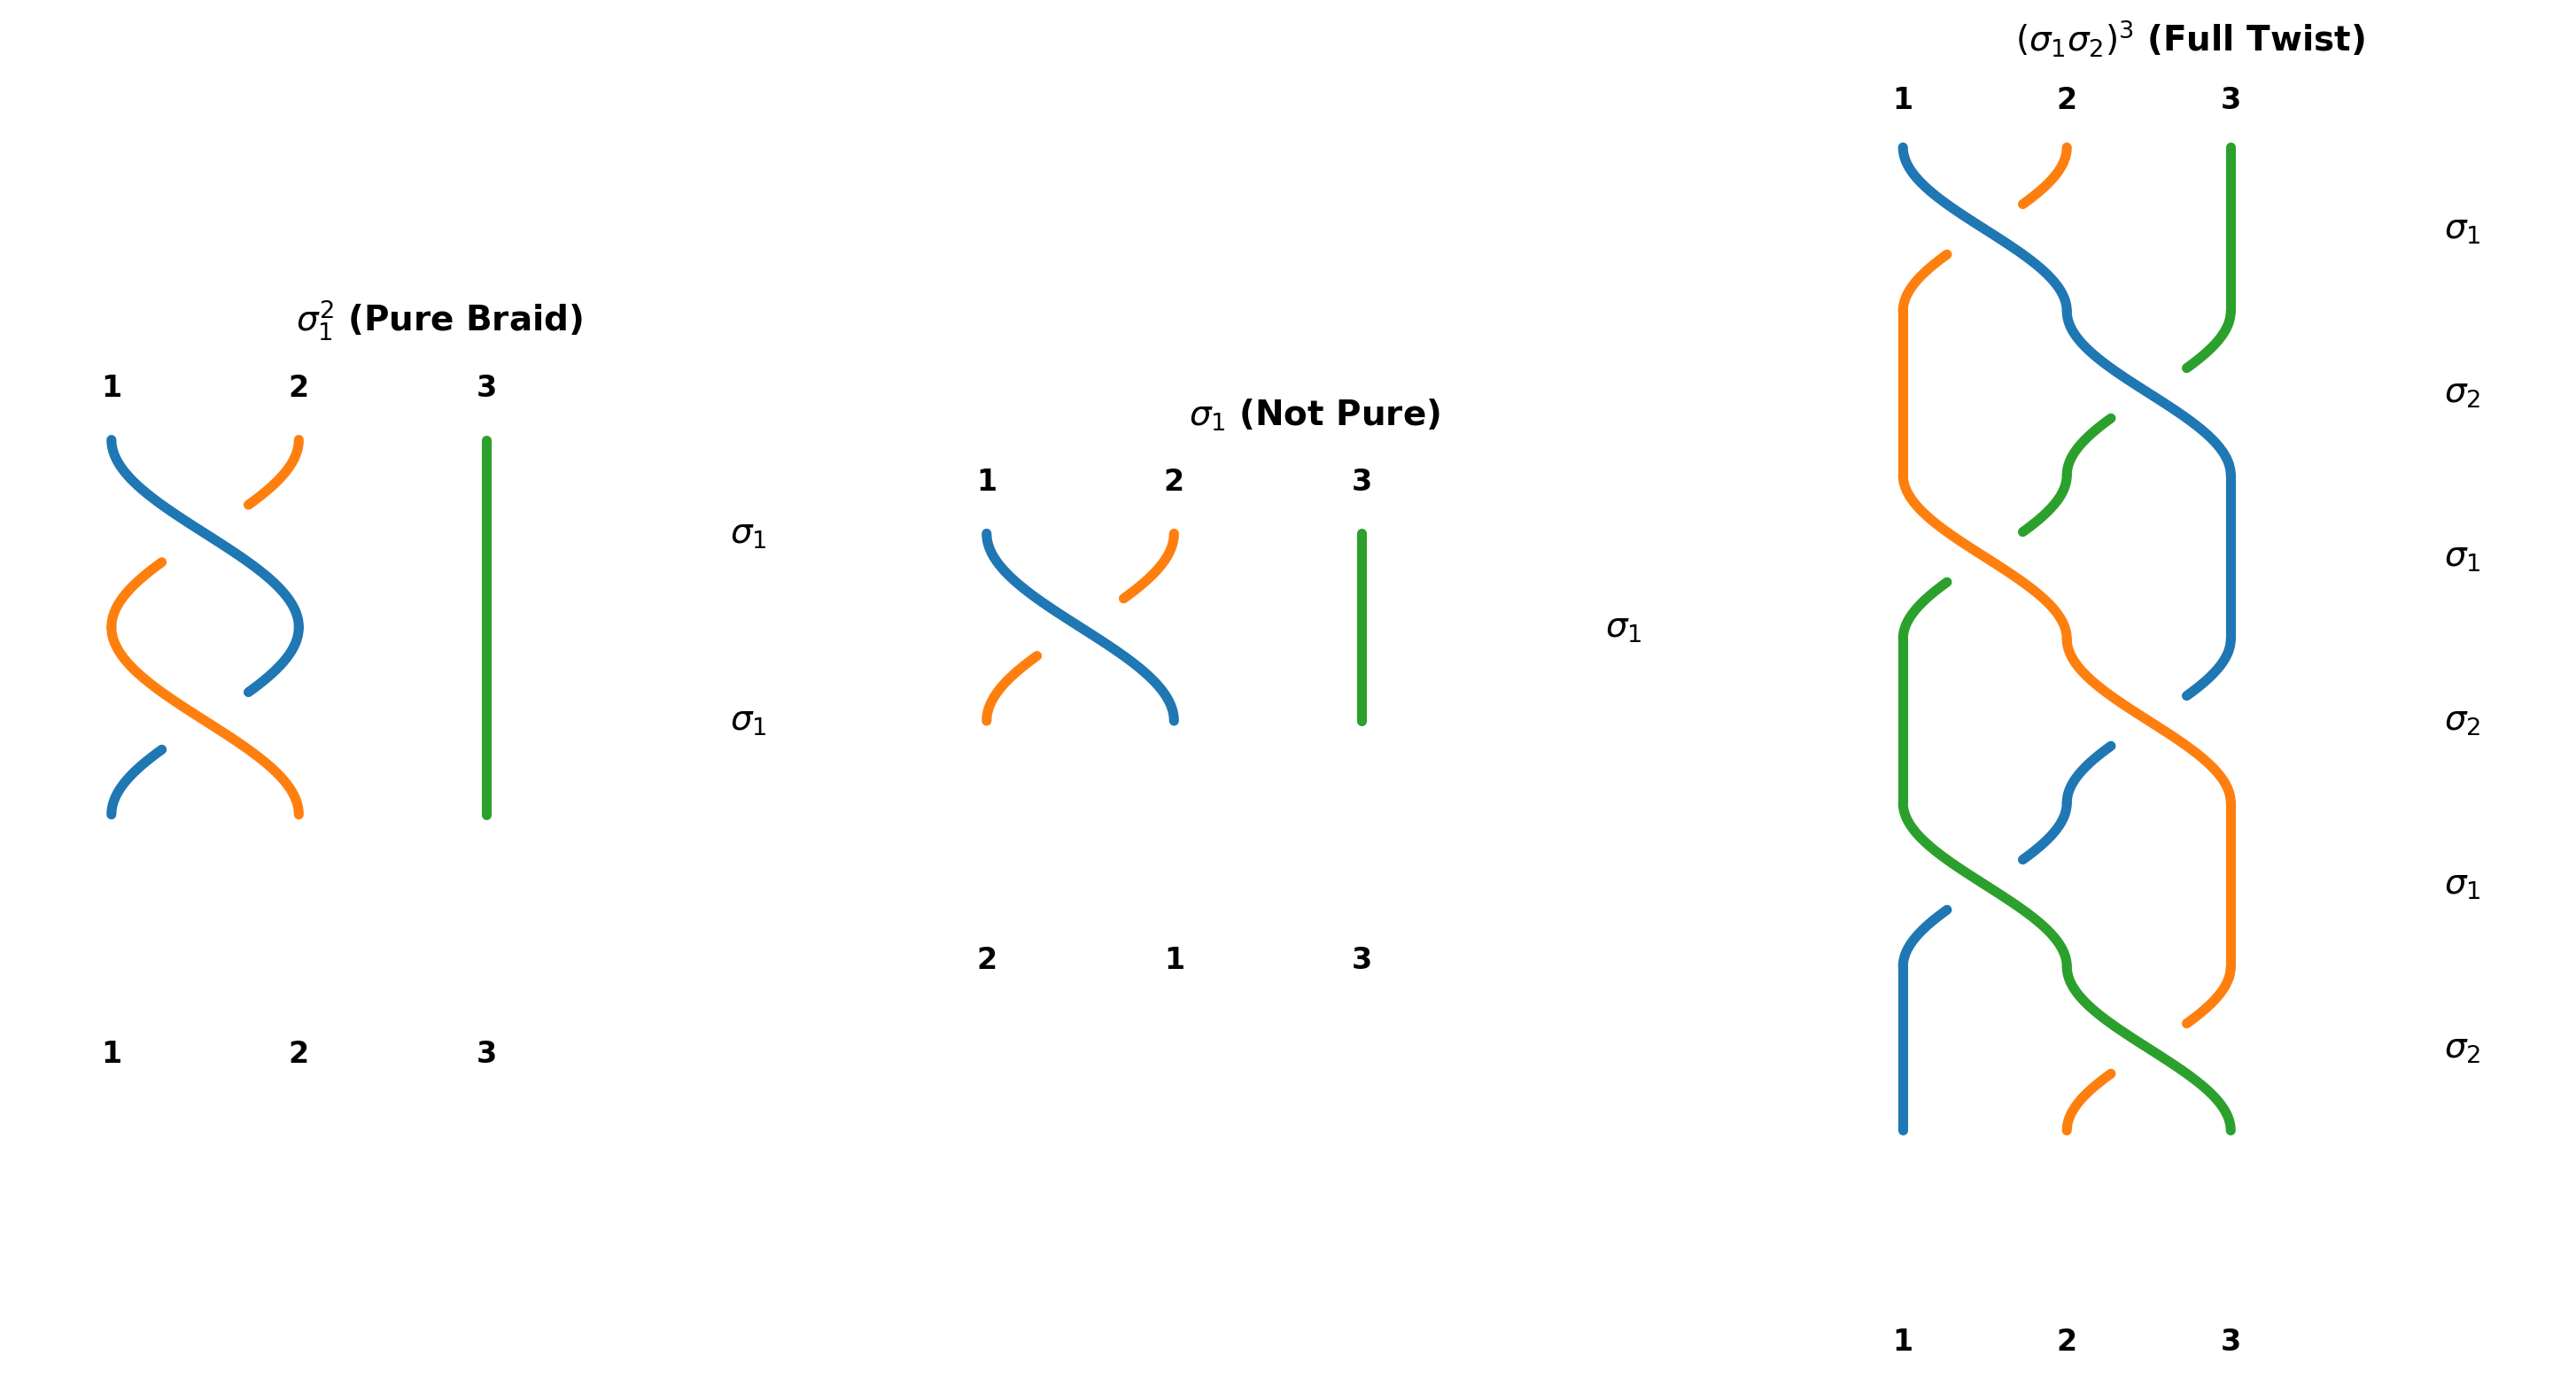

σ₁² is pure: True
σ₁ is pure: False
Full twist is pure: True


In [6]:
# Examples of pure and non-pure braids
pure_braid = Braid(3, [1, 1])  # σ₁² - a pure braid
non_pure = Braid(3, [1])       # σ₁ - not pure
full_twist = Braid(3, [1, 2, 1, 2, 1, 2])  # (σ₁σ₂)³ - full twist (center of B₃)

fig, axes = plt.subplots(1, 3, figsize=(15, 8))

draw_braid(pure_braid, axes[0], title=r'$\sigma_1^2$ (Pure Braid)')
draw_braid(non_pure, axes[1], title=r'$\sigma_1$ (Not Pure)')
draw_braid(full_twist, axes[2], title=r'$(\sigma_1 \sigma_2)^3$ (Full Twist)')

plt.tight_layout()
plt.show()

print(f"σ₁² is pure: {pure_braid.is_pure()}")
print(f"σ₁ is pure: {non_pure.is_pure()}")
print(f"Full twist is pure: {full_twist.is_pure()}")

## 10. Braid Closure and Knots

Every knot and link can be represented as the **closure** of a braid. The closure is obtained by connecting the top endpoints to the corresponding bottom endpoints. This is known as **Alexander's theorem**.

The relationship between braids and knots is given by **Markov's theorem**: two braids have equivalent closures if and only if they are related by:
1. Conjugation: $\beta \sim \alpha^{-1} \beta \alpha$
2. Stabilization: $\beta \sim \beta \sigma_n^{\pm 1}$ (adding a strand)

In [7]:
def draw_braid_closure(braid, ax=None, title=None):
    """
    Draw the closure of a braid (connecting top to bottom).
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    n = braid.n_strands
    generators = braid.generators
    n_crossings = len(generators)
    
    # Colors for strands
    cmap = plt.cm.tab10
    strand_colors = [cmap(i % 10) for i in range(n)]
    
    # Draw the braid portion in the center
    height_per_crossing = 1.0
    braid_height = max(n_crossings, 1) * height_per_crossing
    closure_width = 1.5
    
    # Track strand positions through the braid
    positions = np.zeros((n_crossings + 1, n))
    positions[0] = np.arange(n)
    
    strand_at_pos = list(range(n))
    for t, g in enumerate(generators):
        i = abs(g) - 1
        strand_at_pos[i], strand_at_pos[i+1] = strand_at_pos[i+1], strand_at_pos[i]
        for x in range(n):
            positions[t+1, strand_at_pos[x]] = x
    
    # Draw each strand with its closure
    for strand in range(n):
        color = strand_colors[strand]
        start_pos = positions[0, strand]
        end_pos = positions[-1, strand]
        
        # Draw braid portion
        for t in range(n_crossings):
            y_start = braid_height - t * height_per_crossing
            y_end = braid_height - (t + 1) * height_per_crossing
            x_start = positions[t, strand]
            x_end = positions[t + 1, strand]
            
            g = generators[t]
            crossing_pos = abs(g) - 1
            
            if x_start == crossing_pos or x_start == crossing_pos + 1:
                is_left_strand = (x_start == crossing_pos)
                goes_over = (g > 0 and is_left_strand) or (g < 0 and not is_left_strand)
                
                t_vals = np.linspace(0, 1, 50)
                y_vals = y_start + (y_end - y_start) * t_vals
                x_vals = x_start + (x_end - x_start) * (1 - np.cos(np.pi * t_vals)) / 2
                
                if goes_over:
                    ax.plot(x_vals, y_vals, color=color, linewidth=3, zorder=3)
                else:
                    gap_start, gap_end = 0.35, 0.65
                    mask1 = t_vals < gap_start
                    mask2 = t_vals > gap_end
                    ax.plot(x_vals[mask1], y_vals[mask1], color=color, linewidth=3, zorder=2)
                    ax.plot(x_vals[mask2], y_vals[mask2], color=color, linewidth=3, zorder=2)
            else:
                ax.plot([x_start, x_end], [y_start, y_end], color=color, linewidth=3, zorder=1)
        
        # Draw closure arcs on the right side
        # Top arc: from (start_pos, braid_height) to (end_pos, 0)
        theta = np.linspace(np.pi/2, -np.pi/2, 50)
        arc_center_y = braid_height / 2
        arc_radius_y = braid_height / 2 + 0.3
        arc_center_x = (n - 1) / 2
        
        # Right side closure
        y_arc = arc_center_y + arc_radius_y * np.sin(theta)
        x_offset_top = (n - 1) - start_pos
        x_offset_bot = (n - 1) - end_pos
        x_arc = (n - 1) + closure_width + 0.3 * strand
        
        # Bezier-like curve for closure
        t_vals = np.linspace(0, 1, 50)
        # Top to right
        ax.plot([start_pos, start_pos + closure_width/2 + 0.2*strand], 
                [braid_height, braid_height + 0.3 + 0.15*strand], 
                color=color, linewidth=3, zorder=1)
        ax.plot([start_pos + closure_width/2 + 0.2*strand, end_pos + closure_width/2 + 0.2*strand], 
                [braid_height + 0.3 + 0.15*strand, -0.3 - 0.15*strand], 
                color=color, linewidth=3, zorder=1)
        ax.plot([end_pos + closure_width/2 + 0.2*strand, end_pos], 
                [-0.3 - 0.15*strand, 0], 
                color=color, linewidth=3, zorder=1)
    
    ax.set_xlim(-1, n + closure_width + 1)
    ax.set_ylim(-1, braid_height + 1)
    ax.set_aspect('equal')
    ax.axis('off')
    
    if title:
        ax.set_title(title, fontsize=14, fontweight='bold')
    
    return ax

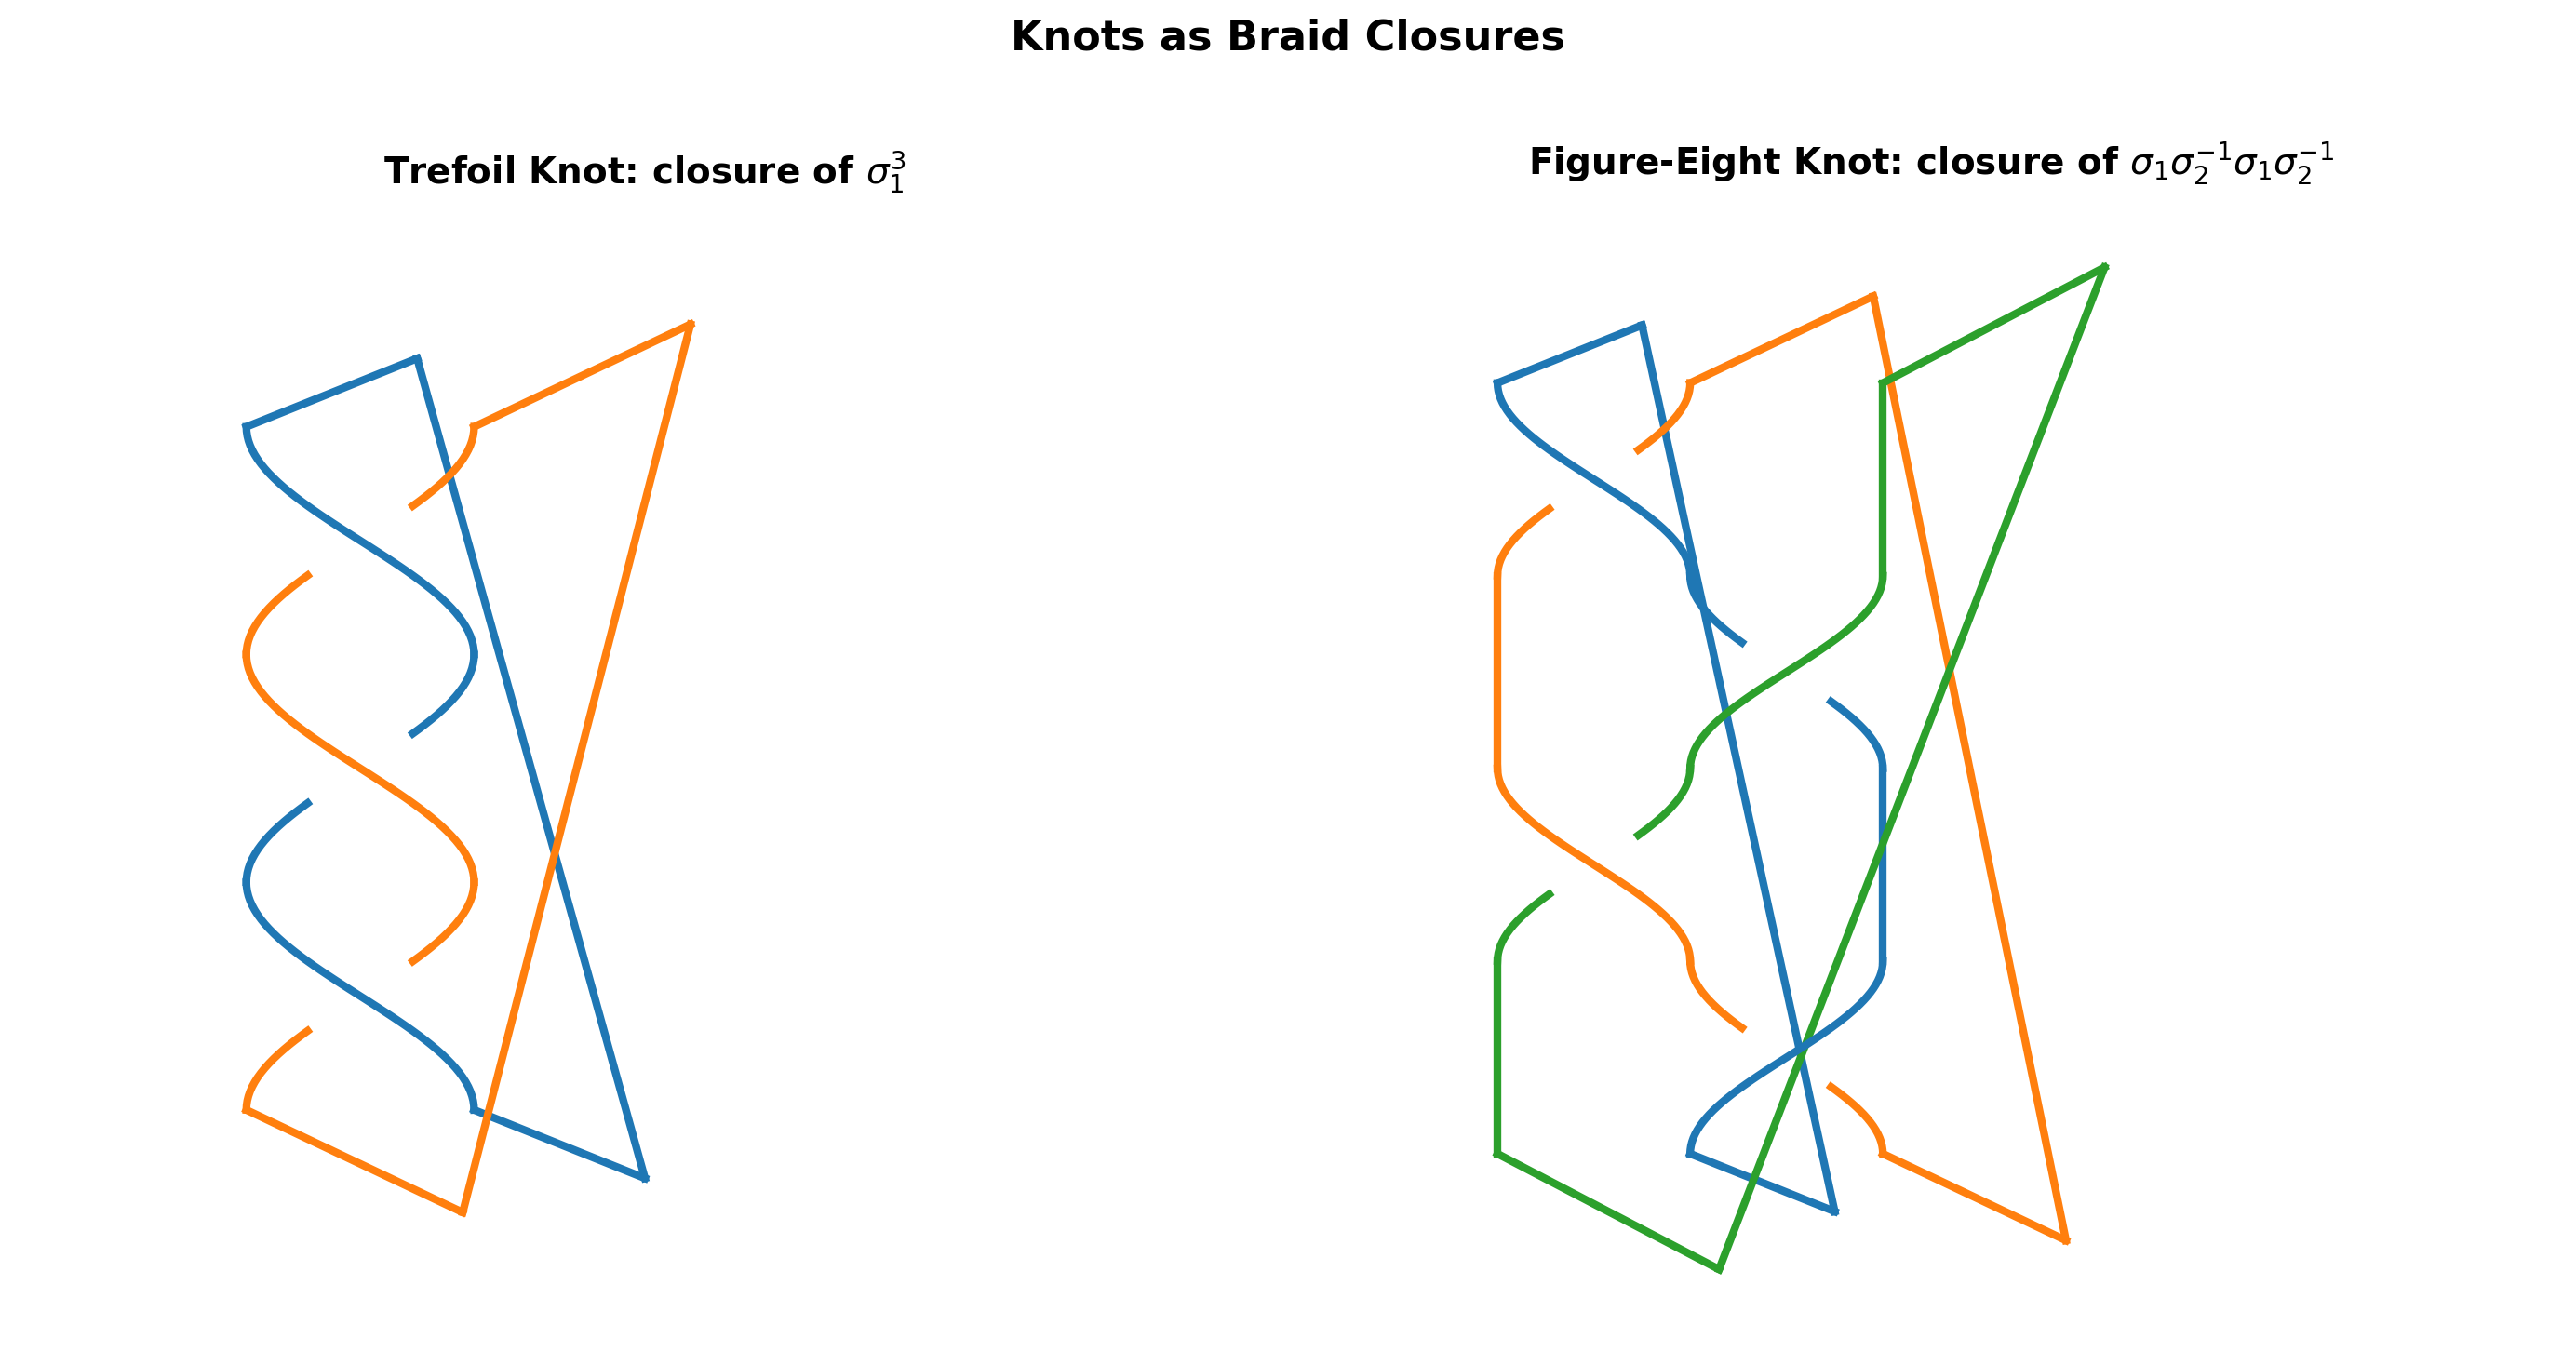

In [8]:
# Famous knots as braid closures
# Trefoil knot: closure of σ₁³ in B₂
trefoil_braid = Braid(2, [1, 1, 1])

# Figure-eight knot: closure of σ₁σ₂⁻¹σ₁σ₂⁻¹ in B₃
figure_eight_braid = Braid(3, [1, -2, 1, -2])

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

draw_braid_closure(trefoil_braid, axes[0], title=r'Trefoil Knot: closure of $\sigma_1^3$')
draw_braid_closure(figure_eight_braid, axes[1], title=r'Figure-Eight Knot: closure of $\sigma_1\sigma_2^{-1}\sigma_1\sigma_2^{-1}$')

plt.suptitle('Knots as Braid Closures', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## 11. Computational Exploration of $B_n$

Let's explore some computational aspects of braid groups, including counting distinct braids of given length.

In [9]:
def count_braids_by_permutation(n_strands, max_length):
    """
    Count braids of each length that produce each permutation.
    """
    from itertools import product
    from collections import defaultdict
    
    results = defaultdict(lambda: defaultdict(int))
    
    generators = list(range(1, n_strands)) + list(range(-(n_strands-1), 0))
    
    for length in range(max_length + 1):
        if length == 0:
            results[length][tuple(range(n_strands))] = 1
        else:
            for gen_seq in product(generators, repeat=length):
                braid = Braid(n_strands, list(gen_seq))
                perm = tuple(braid.permutation())
                results[length][perm] += 1
    
    return results

# Count braids in B_3 up to length 4
print("Counting braids in B₃ by length and resulting permutation...")
print("(This explores the growth of the braid group)\n")

counts = count_braids_by_permutation(3, 4)

for length in range(5):
    total = sum(counts[length].values())
    pure_count = counts[length].get((0, 1, 2), 0)
    print(f"Length {length}: {total} total braids, {pure_count} pure braids")

Counting braids in B₃ by length and resulting permutation...
(This explores the growth of the braid group)

Length 0: 1 total braids, 1 pure braids
Length 1: 4 total braids, 0 pure braids
Length 2: 16 total braids, 8 pure braids
Length 3: 64 total braids, 0 pure braids
Length 4: 256 total braids, 96 pure braids


## 12. Summary Visualization

Let's create a comprehensive visualization showing various aspects of braid groups.

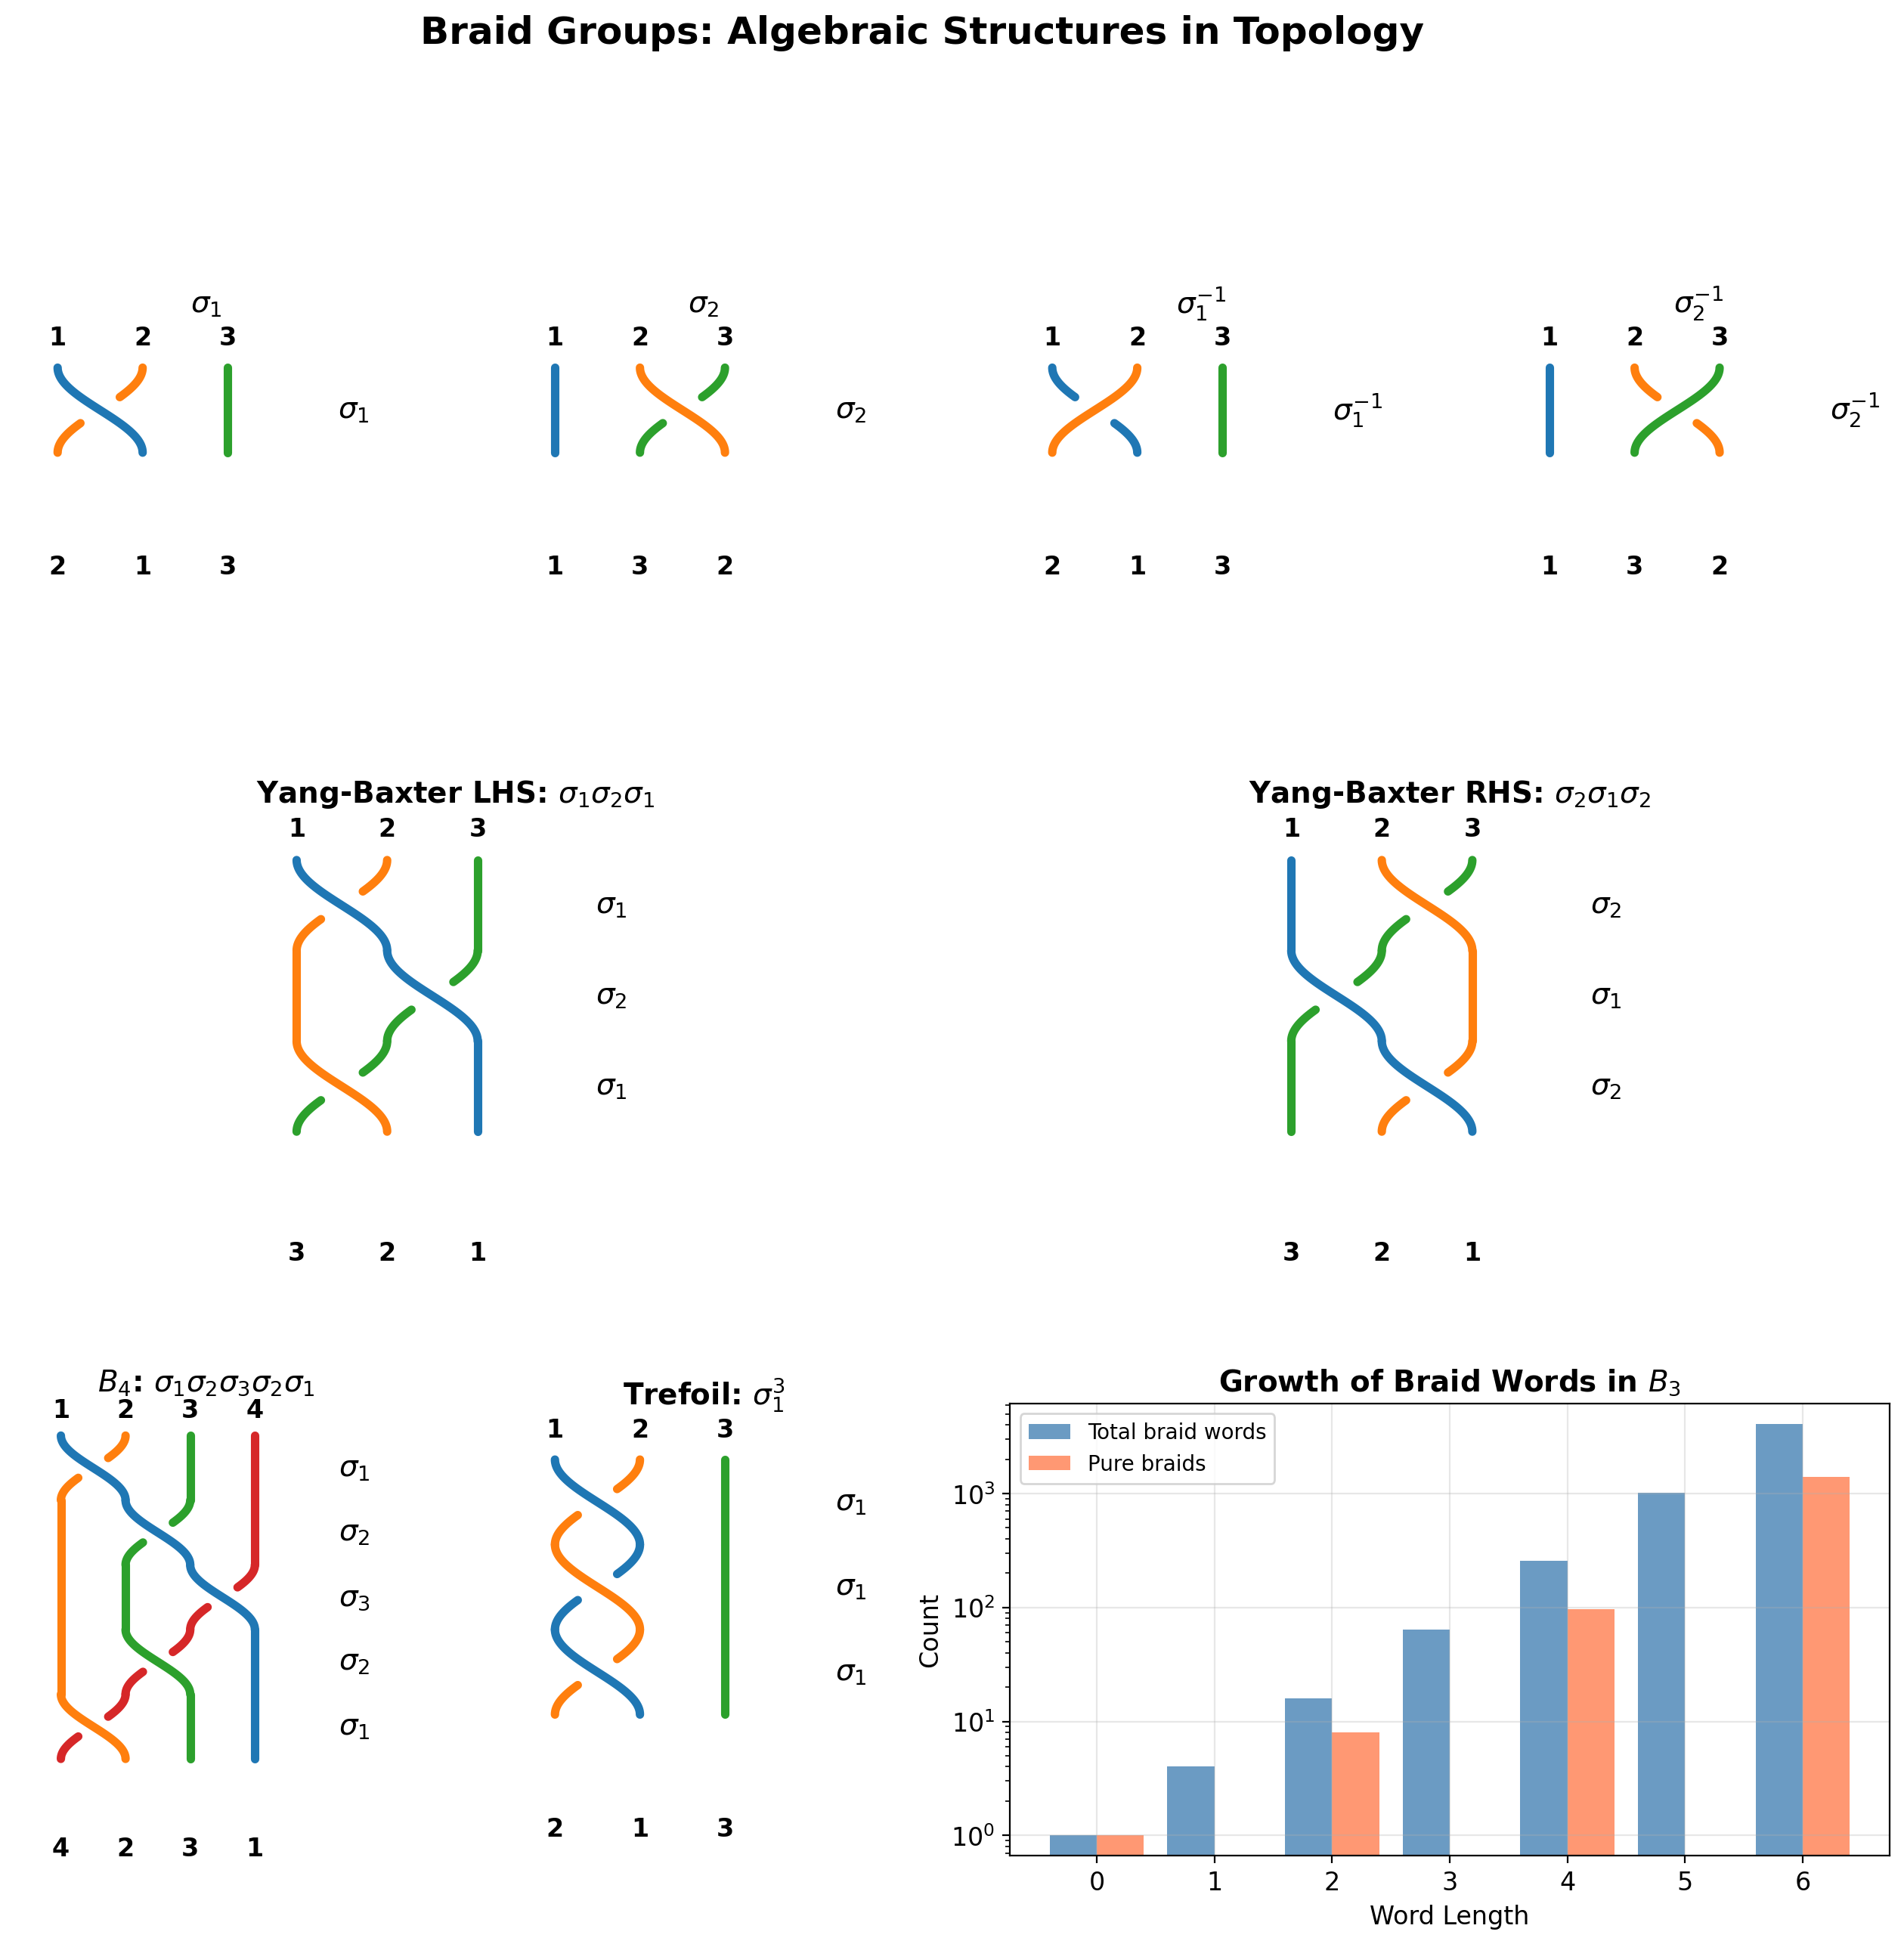


Figure saved to plot.png


In [10]:
# Create a comprehensive figure showing braid group concepts
fig = plt.figure(figsize=(16, 14))

# Create grid spec for complex layout
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# Row 1: Elementary generators
ax1 = fig.add_subplot(gs[0, 0])
draw_braid(Braid(3, [1]), ax1, title=r'$\sigma_1$')

ax2 = fig.add_subplot(gs[0, 1])
draw_braid(Braid(3, [2]), ax2, title=r'$\sigma_2$')

ax3 = fig.add_subplot(gs[0, 2])
draw_braid(Braid(3, [-1]), ax3, title=r'$\sigma_1^{-1}$')

ax4 = fig.add_subplot(gs[0, 3])
draw_braid(Braid(3, [-2]), ax4, title=r'$\sigma_2^{-1}$')

# Row 2: Yang-Baxter and composition
ax5 = fig.add_subplot(gs[1, 0:2])
draw_braid(Braid(3, [1, 2, 1]), ax5, title=r'Yang-Baxter LHS: $\sigma_1\sigma_2\sigma_1$')

ax6 = fig.add_subplot(gs[1, 2:4])
draw_braid(Braid(3, [2, 1, 2]), ax6, title=r'Yang-Baxter RHS: $\sigma_2\sigma_1\sigma_2$')

# Row 3: Complex braids and statistics
ax7 = fig.add_subplot(gs[2, 0])
draw_braid(Braid(4, [1, 2, 3, 2, 1]), ax7, title=r'$B_4$: $\sigma_1\sigma_2\sigma_3\sigma_2\sigma_1$')

ax8 = fig.add_subplot(gs[2, 1])
draw_braid(Braid(3, [1, 1, 1]), ax8, title=r'Trefoil: $\sigma_1^3$')

ax9 = fig.add_subplot(gs[2, 2:4])
# Plot growth of braid words
lengths = range(7)
total_counts = []
pure_counts = []

from itertools import product
for L in lengths:
    gens = [1, 2, -1, -2]
    total = 0
    pure = 0
    if L == 0:
        total = 1
        pure = 1
    else:
        for seq in product(gens, repeat=L):
            total += 1
            b = Braid(3, list(seq))
            if b.is_pure():
                pure += 1
    total_counts.append(total)
    pure_counts.append(pure)

ax9.bar(np.array(list(lengths)) - 0.2, total_counts, 0.4, label='Total braid words', color='steelblue', alpha=0.8)
ax9.bar(np.array(list(lengths)) + 0.2, pure_counts, 0.4, label='Pure braids', color='coral', alpha=0.8)
ax9.set_xlabel('Word Length', fontsize=12)
ax9.set_ylabel('Count', fontsize=12)
ax9.set_title('Growth of Braid Words in $B_3$', fontsize=14, fontweight='bold')
ax9.legend(fontsize=10)
ax9.set_yscale('log')
ax9.grid(True, alpha=0.3)

plt.suptitle('Braid Groups: Algebraic Structures in Topology', fontsize=18, fontweight='bold', y=0.98)

plt.savefig('braid_groups_analysis.png', dpi=150, bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

print("\nFigure saved to plot.png")

## 13. Conclusions

In this notebook, we have explored:

1. **Geometric and algebraic definitions** of braid groups $B_n$
2. **The Artin presentation** with generators $\sigma_i$ and the Yang-Baxter relation
3. **The relationship to symmetric groups** via the short exact sequence $1 \to P_n \to B_n \to S_n \to 1$
4. **Pure braids** and the center of $B_n$
5. **The connection to knot theory** via Alexander's theorem
6. **Computational aspects** including counting and visualization

Braid groups continue to be an active area of research with applications in:
- **Cryptography** (braid group cryptosystems)
- **Quantum computing** (topological quantum computers using anyons)
- **Statistical mechanics** (Yang-Baxter equation)
- **Algebraic geometry** (configuration spaces)

### References

1. Artin, E. (1947). "Theory of braids." *Annals of Mathematics*, 48(1), 101-126.
2. Birman, J. S. (1974). *Braids, Links, and Mapping Class Groups*. Princeton University Press.
3. Kassel, C., & Turaev, V. (2008). *Braid Groups*. Springer.